In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [6]:
df = pd.read_csv('../data/clean_reclean/time_series.csv')  # Ajuste le chemin si besoin

# Création de la colonne datetime
df['Date'] = pd.to_datetime(df['YrSold'].astype(str) + '-' + df['MoSold'].astype(str) + '-01')

# Agrégation mensuelle
monthly_avg = df.groupby('Date')['SalePrice'].mean().reset_index()
monthly_avg.columns = ['Date', 'AverageSalePrice']

# Mise en index datetime
monthly_avg.set_index('Date', inplace=True)
monthly_avg.index.name = 'Date'

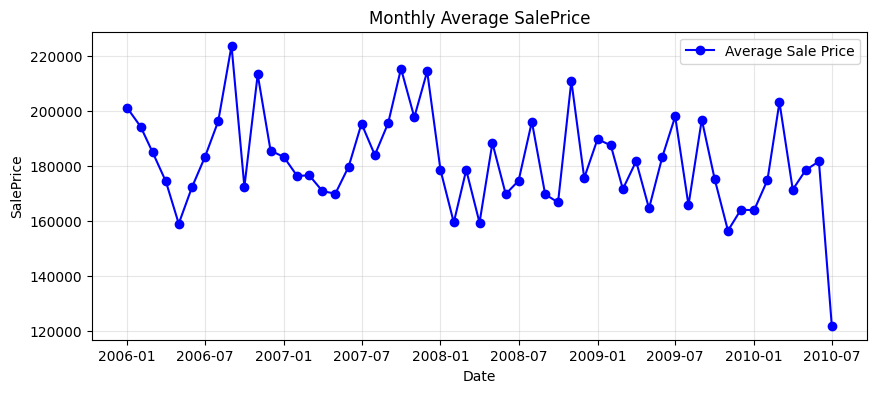

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(monthly_avg, label='Average Sale Price', marker='o', linestyle='-', color='blue')
plt.grid(True, alpha=0.3)
plt.title('Monthly Average SalePrice')
plt.xlabel('Date')
plt.ylabel('SalePrice')
plt.legend()
plt.show()

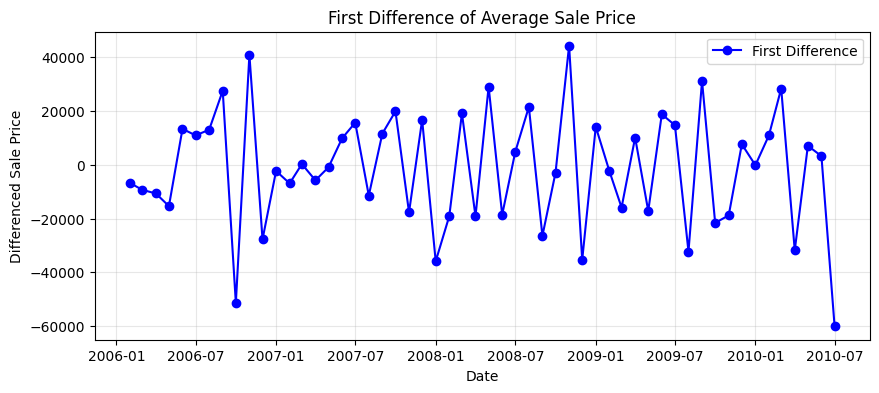

In [8]:
monthly_diff = monthly_avg['AverageSalePrice'].diff().dropna()

plt.figure(figsize=(10, 4))
plt.plot(monthly_diff.index, monthly_diff.values, label='First Difference', marker='o', linestyle='-', color='blue')
plt.grid(True, alpha=0.3)
plt.title('First Difference of Average Sale Price')
plt.xlabel('Date')
plt.ylabel('Differenced Sale Price')
plt.legend()
plt.show()

In [9]:
X_orig = np.arange(len(monthly_avg)).reshape(-1, 1)
X_orig_const = sm.add_constant(X_orig)
y_orig = monthly_avg['AverageSalePrice'].values
model_orig = sm.OLS(y_orig, X_orig_const).fit()
original_p_values = model_orig.pvalues[1]
print(f"Original series trend p-value: {original_p_values:.4f}")

Original series trend p-value: 0.0254


In [10]:
log_avg = np.log(monthly_avg['AverageSalePrice'])
log_diff = log_avg.diff().dropna()

X_log_diff = np.arange(len(log_diff)).reshape(-1, 1)
X_log_diff_const = sm.add_constant(X_log_diff)
y_log_diff = log_diff.values
model_log_diff = sm.OLS(y_log_diff, X_log_diff_const).fit()
log_diff_p_value = model_log_diff.pvalues[1]
print(f"Log-differenced series trend p-value: {log_diff_p_value:.4f}")

Log-differenced series trend p-value: 0.5835


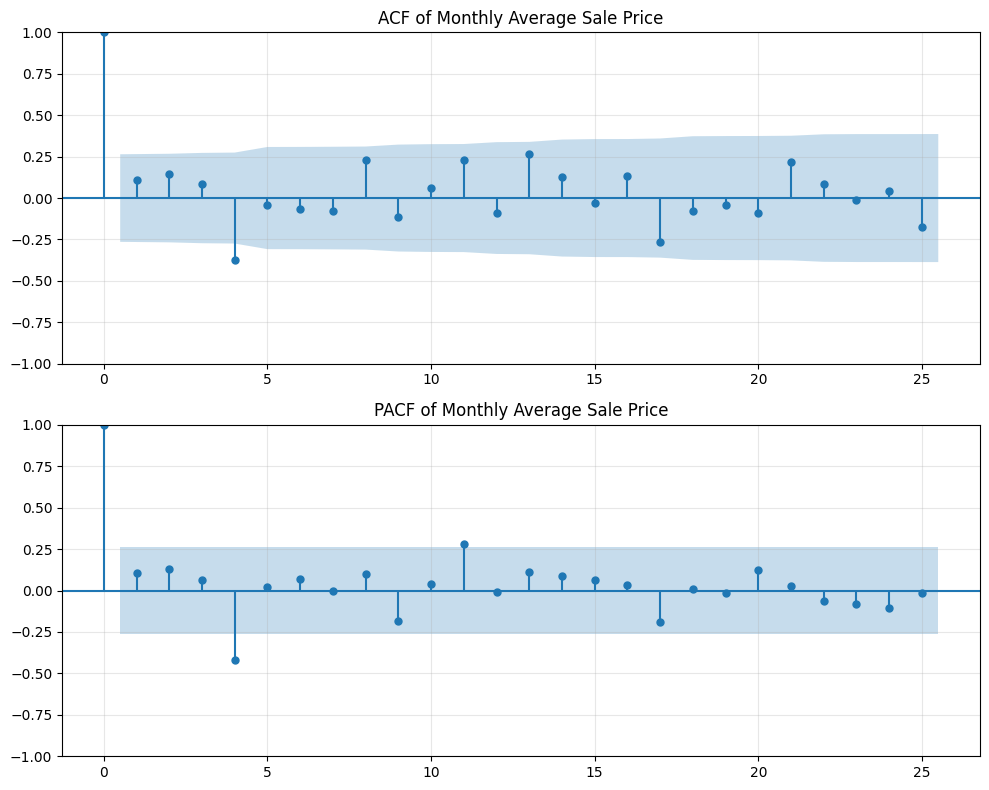

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(monthly_avg, lags=25, ax=axes[0])
axes[0].set_title('ACF of Monthly Average Sale Price')
axes[0].grid(True, alpha=0.3)

plot_pacf(monthly_avg, lags=25, ax=axes[1])
axes[1].set_title('PACF of Monthly Average Sale Price')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# model_arima_4 = ARIMA(monthly_avg, order=(4, 1, 0)).fit()
# print(model_arima_4.summary())